# Importing the Packages

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from keras.datasets import fashion_mnist

In [6]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix

In [7]:
import heapq

# Reading the Dataset and Preprocessing

In [8]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [9]:
classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
           5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

# Visualization Classifier

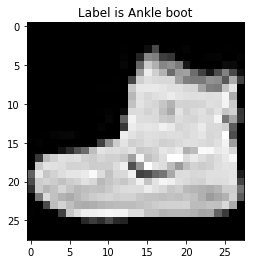

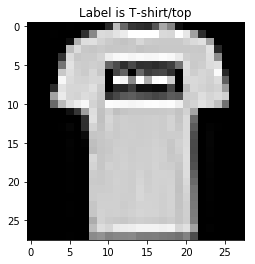

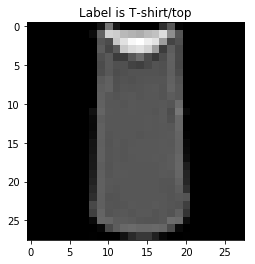

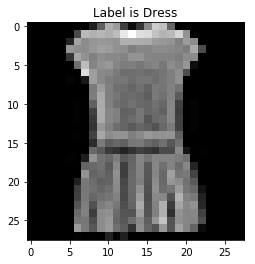

In [10]:
def create_visual(X, y=None):
    if y is None:
        y = 'unknown'
    else:
        y = classes[y]
    plt.title('Label is {label}'.format(label=y))
    plt.imshow(X, cmap='gray')
    plt.show()
    
create_visual(x_train[0], y_train[0])
create_visual(x_train[1], y_train[1])
create_visual(x_train[2], y_train[2])
create_visual(x_train[3], y_train[3])

# Preprocessing

In [11]:
x_train_prep = x_train / 255
x_test_prep = x_test / 255

x_train_prep_1d = x_train_prep.reshape(-1, 28 * 28)
x_test_prep_1d = x_test_prep.reshape(-1, 28 * 28)

x_train_prep_3d = x_train_prep.reshape(-1, 28, 28, 1)
x_test_prep_3d = x_test_prep.reshape(-1, 28, 28, 1)

# Creating More Classifiers

In [13]:
def find_example(model, x, y, true_class, predicted_class):
    y_true = y
    y_pred = model.predict(x)
    found_index = None
    for index, (current_y_true, current_y_pred) in enumerate(zip(y_true, y_pred)):
        if current_y_true == true_class and current_y_pred == predicted_class:
            found_index = index
            break
    return found_index

def plot_example(model, x, y, true_class, predicted_class, value=None):
    index = find_example(model, x, y, true_class, predicted_class)
    print('True class:', classes[true_class])
    print('Predicted class:', classes[predicted_class])
    if value is not None:
        print('Misclassified', value, 'times')
    if index is not None:
        plt.imshow(x_test_prep[index])
        plt.show()
    print('')
    
def comm_matrix(model, x, y, inspect_n=10):
    y_pred = model.predict(x)
    conf_matrix = confusion_matrix(y, y_pred)
    print('Confusion matrix:')
    print(conf_matrix)
    print('')
    for _ in range(10):
        conf_matrix[_][_] = 0
    conf_matrix_flat = conf_matrix.reshape(-1, 1)
    biggest_indices = heapq.nlargest(inspect_n, range(len(conf_matrix_flat)), conf_matrix_flat.take)
    biggest_indices = np.unravel_index(biggest_indices, conf_matrix.shape)
    highest_values = conf_matrix[biggest_indices]
    for x_index, y_index, value in zip(biggest_indices[0], biggest_indices[1], highest_values):
        plot_example(model, x, y, x_index, y_index, value)

# Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic_param_grid = {'C': [0.001, 0.01, 0.1, 1., 10., 100.]}
lr_gridsearch = GridSearchCV(cv=4, estimator=logistic_regression, param_grid=logistic_param_grid, scoring='accuracy')
lr_gridsearch.fit(x_train_prep_1d, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [15]:
print(lr_gridsearch.best_params_)
print(lr_gridsearch.best_score_)

{'C': 0.1}
0.856266666667


Confusion matrix:
[[807   2  18  51   4   3 106   0   9   0]
 [  2 957   4  24   6   0   6   0   1   0]
 [ 19   3 734   9 131   1  93   0  10   0]
 [ 29  12  15 871  28   0  41   0   4   0]
 [  0   1 109  37 755   1  89   0   8   0]
 [  0   0   0   1   0 928   0  48   3  20]
 [130   2 120  39 102   1 581   0  25   0]
 [  0   0   0   0   0  33   0 935   0  32]
 [  6   1   5  11   4   5  22   5 941   0]
 [  0   0   0   0   0  14   0  44   1 941]]

True class: Pullover
Predicted class: Coat
Misclassified 131 times


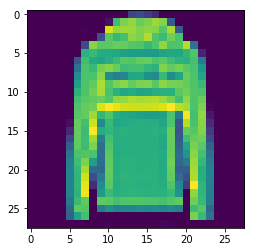


True class: Shirt
Predicted class: T-shirt/top
Misclassified 130 times


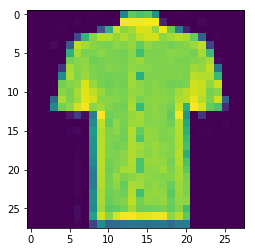


True class: Shirt
Predicted class: Pullover
Misclassified 120 times


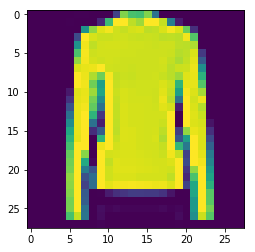


True class: Coat
Predicted class: Pullover
Misclassified 109 times


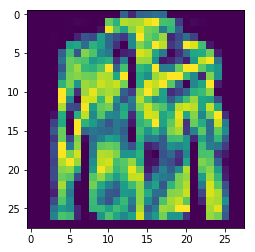


True class: T-shirt/top
Predicted class: Shirt
Misclassified 106 times


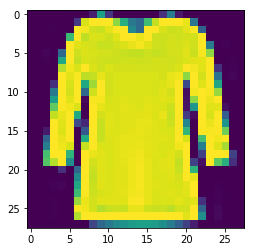


True class: Shirt
Predicted class: Coat
Misclassified 102 times


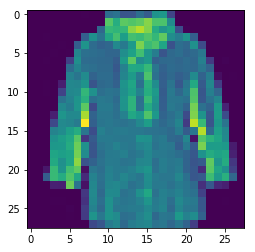


True class: Pullover
Predicted class: Shirt
Misclassified 93 times


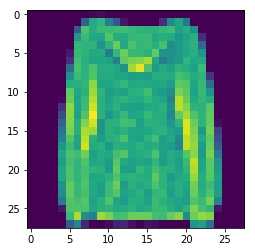


True class: Coat
Predicted class: Shirt
Misclassified 89 times


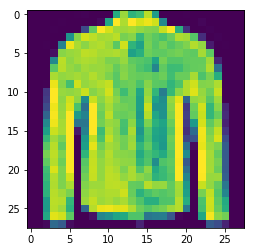


True class: T-shirt/top
Predicted class: Dress
Misclassified 51 times


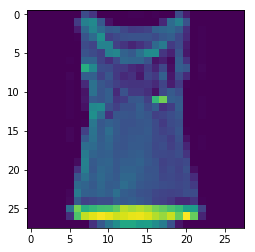


True class: Sandal
Predicted class: Sneaker
Misclassified 48 times


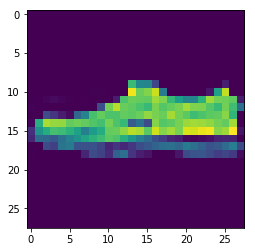

In [16]:
comm_matrix(lr_gridsearch, x_test_prep_1d, y_test)

# Naive Bayes Classifier

In [17]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
print(np.mean(cross_val_score(estimator=naive_bayes, cv=4, scoring='accuracy', X=x_train_prep_1d, y=y_train)))
naive_bayes.fit(x_train_prep_1d, y_train)

0.590066666667


GaussianNB(priors=None)

Confusion matrix:
[[586  64  29 162 110   0  20   0  29   0]
 [  1 939  14  36   7   0   1   0   2   0]
 [  7  14 324  65 545   0  23   0  22   0]
 [  9 387   6 545  43   0   4   0   6   0]
 [  0  34  44 131 779   0   4   0   8   0]
 [  0   0   1   1   0 278   3 660   5  52]
 [117  34 112 200 435   0  40   0  62   0]
 [  0   0   0   0   0   3   0 988   0   9]
 [  0   2  19  85 149   3  27   4 710   1]
 [  0   0   1   1   0  16   3 304   8 667]]

True class: Sandal
Predicted class: Sneaker
Misclassified 660 times


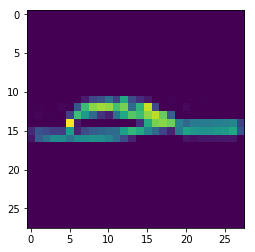


True class: Pullover
Predicted class: Coat
Misclassified 545 times


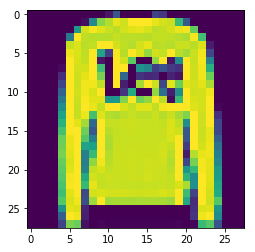


True class: Shirt
Predicted class: Coat
Misclassified 435 times


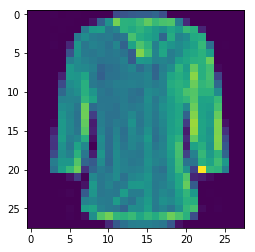


True class: Dress
Predicted class: Trouser
Misclassified 387 times


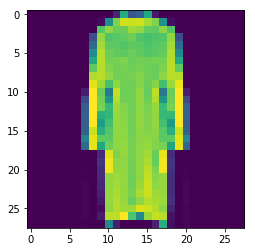


True class: Ankle boot
Predicted class: Sneaker
Misclassified 304 times


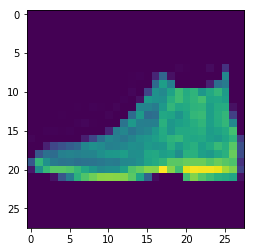


True class: Shirt
Predicted class: Dress
Misclassified 200 times


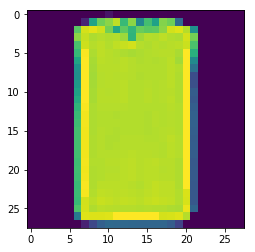


True class: T-shirt/top
Predicted class: Dress
Misclassified 162 times


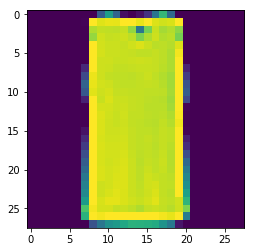


True class: Bag
Predicted class: Coat
Misclassified 149 times


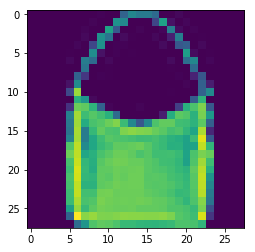


True class: Coat
Predicted class: Dress
Misclassified 131 times


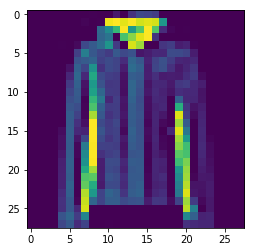


True class: Shirt
Predicted class: T-shirt/top
Misclassified 117 times


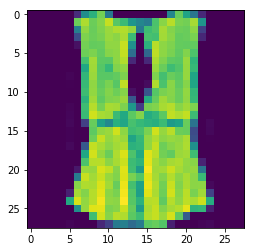

In [18]:
comm_matrix(naive_bayes, x_test_prep_1d, y_test)

# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
rf_param_grid = {'max_depth': [3, 5, 7, 9], 
                 'max_features': ['auto', 'log2', 0.15, None]}
rf_gridsearch = GridSearchCV(cv=4, estimator=random_forest, param_grid=rf_param_grid, scoring='accuracy', n_jobs=1)
rf_gridsearch.fit(x_train_prep_1d, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 9], 'max_features': ['auto', 'log2', 0.15, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [20]:
print(rf_gridsearch.best_params_)
print(rf_gridsearch.best_score_)

{'max_depth': 9, 'max_features': 0.15}
0.848083333333


Confusion matrix:
[[829   0  21  55   9   1  71   0  14   0]
 [  6 939   5  37   3   0   8   0   2   0]
 [  9   0 725   9 215   0  37   0   5   0]
 [ 23   2  19 887  44   0  22   0   3   0]
 [  0   1 102  46 805   0  44   0   2   0]
 [  0   0   0   1   0 921   0  54   8  16]
 [182   1 163  40 117   0 475   0  22   0]
 [  0   0   0   0   0   9   0 924   1  66]
 [  0   2  17   3   5   2   6   5 960   0]
 [  0   0   0   0   0   6   1  53   3 937]]

True class: Pullover
Predicted class: Coat
Misclassified 215 times


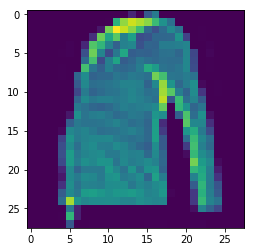


True class: Shirt
Predicted class: T-shirt/top
Misclassified 182 times


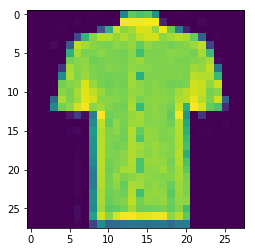


True class: Shirt
Predicted class: Pullover
Misclassified 163 times


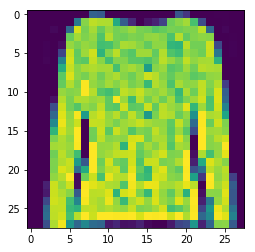


True class: Shirt
Predicted class: Coat
Misclassified 117 times


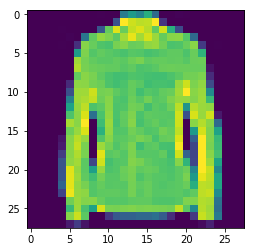


True class: Coat
Predicted class: Pullover
Misclassified 102 times


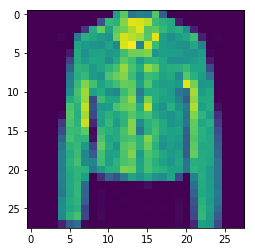


True class: T-shirt/top
Predicted class: Shirt
Misclassified 71 times


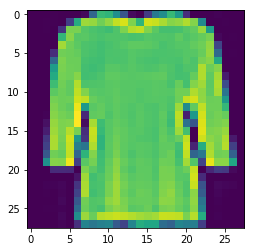


True class: Sneaker
Predicted class: Ankle boot
Misclassified 66 times


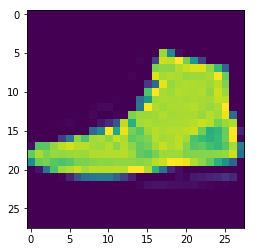


True class: T-shirt/top
Predicted class: Dress
Misclassified 55 times


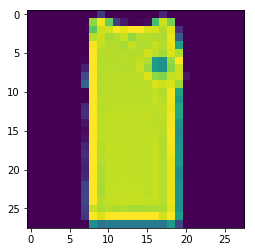


True class: Sandal
Predicted class: Sneaker
Misclassified 54 times


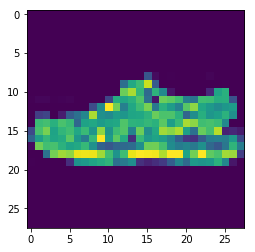


True class: Ankle boot
Predicted class: Sneaker
Misclassified 53 times


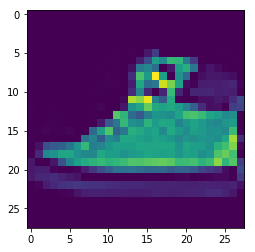

In [21]:
comm_matrix(rf_gridsearch, x_test_prep_1d, y_test)


# Convolutional Neural Network

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import sparse_categorical_accuracy, sparse_categorical_crossentropy

In [23]:
class ConvModel:
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        
    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

    def predict_proba(self, X):
        return self.model.predict(X)

In [24]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model.add(Conv2D(16, (3, 3), activation='sigmoid'))
model.add(Conv2D(8, (3, 3), activation='sigmoid'))
model.add(Flatten())
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

optimizer = Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[sparse_categorical_accuracy])

conv_model_3c_2d = ConvModel(model)
conv_model_3c_2d.fit(x_train_prep_3d, y_train, batch_size=32, epochs=20, validation_data=(x_test_prep_3d, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 107s 2ms/step - loss: 0.9416 - sparse_categorical_accuracy: 0.6822 - val_loss: 0.5758 - val_sparse_categorical_accuracy: 0.7971
Epoch 2/20
60000/60000 [==============================] - 112s 2ms/step - loss: 0.5247 - sparse_categorical_accuracy: 0.8132 - val_loss: 0.5208 - val_sparse_categorical_accuracy: 0.8169
Epoch 3/20
60000/60000 [==============================] - 154s 3ms/step - loss: 0.4650 - sparse_categorical_accuracy: 0.8338 - val_loss: 0.4719 - val_sparse_categorical_accuracy: 0.8318
Epoch 4/20
60000/60000 [==============================] - 163s 3ms/step - loss: 0.4255 - sparse_categorical_accuracy: 0.8483 - val_loss: 0.4372 - val_sparse_categorical_accuracy: 0.8410
Epoch 5/20
60000/60000 [==============================] - 140s 2ms/step - loss: 0.3942 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.4097 - val_sparse_categorical_accuracy: 0.8503
Epoch 6/20
60000/600

Confusion matrix:
[[815   0  15  10   4   1 147   0   8   0]
 [  3 974   2  13   4   0   2   0   2   0]
 [ 14   2 839   8  51   1  80   0   5   0]
 [ 29   9  14 874  42   0  30   0   2   0]
 [  1   1  46  21 856   0  73   0   2   0]
 [  0   0   0   1   0 976   0  16   2   5]
 [ 94   4  65  18  88   0 721   0  10   0]
 [  0   0   0   0   0  13   0 974   0  13]
 [  4   3   5   3   1   5  13   6 960   0]
 [  0   0   0   0   0   9   0  43   1 947]]

True class: T-shirt/top
Predicted class: Shirt
Misclassified 147 times


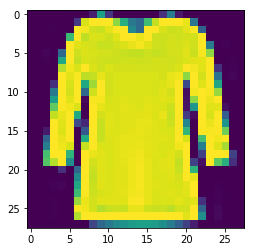


True class: Shirt
Predicted class: T-shirt/top
Misclassified 94 times


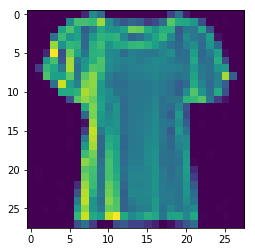


True class: Shirt
Predicted class: Coat
Misclassified 88 times


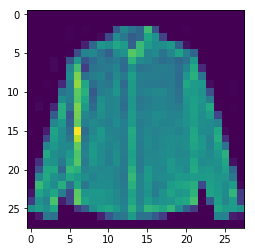


True class: Pullover
Predicted class: Shirt
Misclassified 80 times


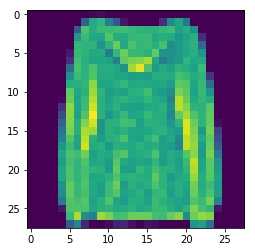


True class: Coat
Predicted class: Shirt
Misclassified 73 times


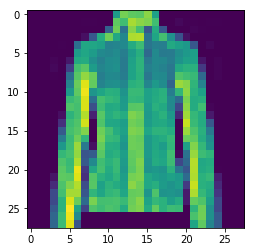


True class: Shirt
Predicted class: Pullover
Misclassified 65 times


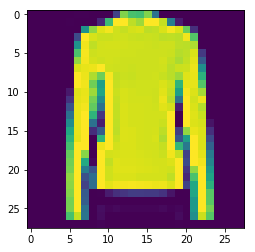


True class: Pullover
Predicted class: Coat
Misclassified 51 times


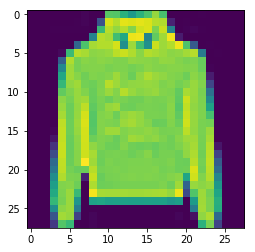


True class: Coat
Predicted class: Pullover
Misclassified 46 times


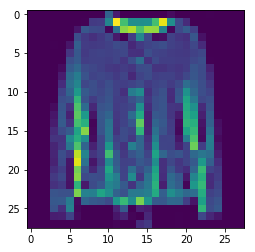


True class: Ankle boot
Predicted class: Sneaker
Misclassified 43 times


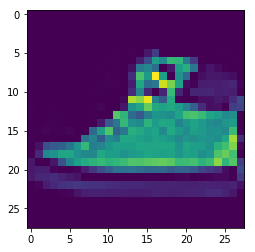


True class: Dress
Predicted class: Coat
Misclassified 42 times


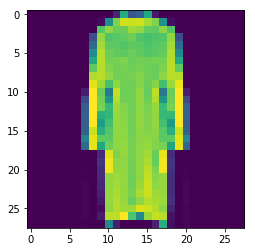

In [25]:
comm_matrix(conv_model_3c_2d, x_test_prep_3d, y_test)

# Convolutional Neural Network Without Dropping

In [26]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model.add(Conv2D(8, (3, 3), activation='sigmoid'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

optimizer = Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[sparse_categorical_accuracy])

conv_model_2c_1d = ConvModel(model)
conv_model_2c_1d.fit(x_train_prep_3d, y_train, batch_size=32, epochs=5, validation_data=(x_test_prep_3d, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 67s 1ms/step - loss: 0.7261 - sparse_categorical_accuracy: 0.7369 - val_loss: 0.5369 - val_sparse_categorical_accuracy: 0.8083
Epoch 2/5
60000/60000 [==============================] - 66s 1ms/step - loss: 0.4625 - sparse_categorical_accuracy: 0.8326 - val_loss: 0.4686 - val_sparse_categorical_accuracy: 0.8283
Epoch 3/5
60000/60000 [==============================] - 66s 1ms/step - loss: 0.4258 - sparse_categorical_accuracy: 0.8477 - val_loss: 0.4477 - val_sparse_categorical_accuracy: 0.8388
Epoch 4/5
60000/60000 [==============================] - 63s 1ms/step - loss: 0.4004 - sparse_categorical_accuracy: 0.8561 - val_loss: 0.4135 - val_sparse_categorical_accuracy: 0.8545
Epoch 5/5
60000/60000 [==============================] - 69s 1ms/step - loss: 0.3819 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.4017 - val_sparse_categorical_accuracy: 0.8573


Confusion matrix:
[[779   1  24  63   5   1 110   0  17   0]
 [  3 957   5  27   4   0   3   0   1   0]
 [ 11   0 829   9  75   0  66   0  10   0]
 [ 16  13  21 890  26   0  27   0   7   0]
 [  1   0 184  39 686   1  83   0   6   0]
 [  0   0   0   1   0 954   0  30   2  13]
 [135   1 138  43  67   0 584   0  32   0]
 [  0   0   0   0   0  10   0 970   0  20]
 [  0   0   2   3   2   6   8   6 973   0]
 [  0   0   0   0   0   8   0  40   1 951]]

True class: Coat
Predicted class: Pullover
Misclassified 184 times


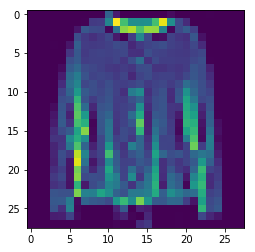


True class: Shirt
Predicted class: Pullover
Misclassified 138 times


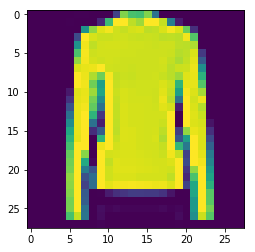


True class: Shirt
Predicted class: T-shirt/top
Misclassified 135 times


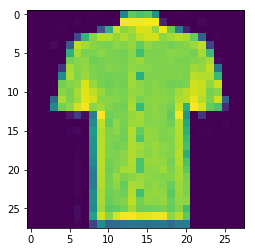


True class: T-shirt/top
Predicted class: Shirt
Misclassified 110 times


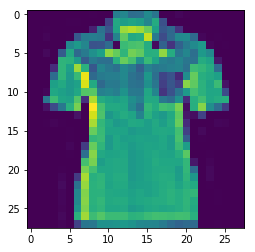


True class: Coat
Predicted class: Shirt
Misclassified 83 times


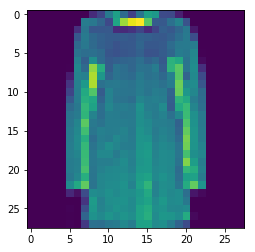


True class: Pullover
Predicted class: Coat
Misclassified 75 times


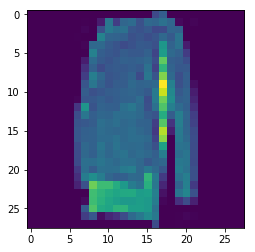


True class: Shirt
Predicted class: Coat
Misclassified 67 times


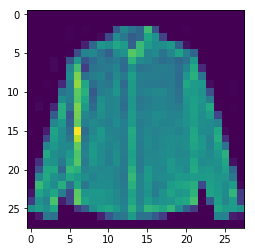


True class: Pullover
Predicted class: Shirt
Misclassified 66 times


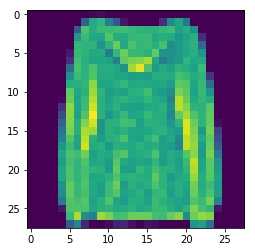


True class: T-shirt/top
Predicted class: Dress
Misclassified 63 times


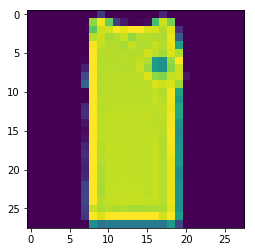


True class: Shirt
Predicted class: Dress
Misclassified 43 times


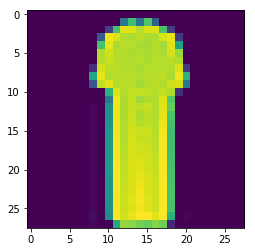

In [27]:
comm_matrix(conv_model_2c_1d, x_test_prep_3d, y_test)


# Done in Three Layers

In [28]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3), activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Conv2D(16, (3, 3), activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

optimizer = Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[sparse_categorical_accuracy])

conv_model_3c_2d_do10 = ConvModel(model)
conv_model_3c_2d_do10.fit(x_train_prep_3d, y_train, batch_size=32, epochs=40, validation_data=(x_test_prep_3d, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 229s 4ms/step - loss: 1.2397 - sparse_categorical_accuracy: 0.5612 - val_loss: 0.5618 - val_sparse_categorical_accuracy: 0.8027
Epoch 2/40
60000/60000 [==============================] - 238s 4ms/step - loss: 0.4635 - sparse_categorical_accuracy: 0.8375 - val_loss: 0.4335 - val_sparse_categorical_accuracy: 0.8428
Epoch 3/40
60000/60000 [==============================] - 236s 4ms/step - loss: 0.3828 - sparse_categorical_accuracy: 0.8634 - val_loss: 0.3728 - val_sparse_categorical_accuracy: 0.8638
Epoch 4/40
60000/60000 [==============================] - 243s 4ms/step - loss: 0.3439 - sparse_categorical_accuracy: 0.8740 - val_loss: 0.3477 - val_sparse_categorical_accuracy: 0.8765
Epoch 5/40
60000/60000 [==============================] - 257s 4ms/step - loss: 0.3149 - sparse_categorical_accuracy: 0.8846 - val_loss: 0.3379 - val_sparse_categorical_accuracy: 0.8797
Epoch 6/40
60000/600

Confusion matrix:
[[883   0  22  14   3   1  69   0   8   0]
 [  2 972   1  13   5   0   6   0   1   0]
 [ 16   2 889   9  45   1  36   0   2   0]
 [ 20   6  23 895  35   0  17   0   4   0]
 [  1   2  91  25 833   0  48   0   0   0]
 [  0   0   1   1   0 968   0  17   1  12]
 [153   2 105  19  75   0 630   0  16   0]
 [  0   0   0   0   0  11   0 962   0  27]
 [  3   1   7   6   5   1   6   3 968   0]
 [  0   0   0   0   0   4   0  33   0 963]]

True class: Shirt
Predicted class: T-shirt/top
Misclassified 153 times


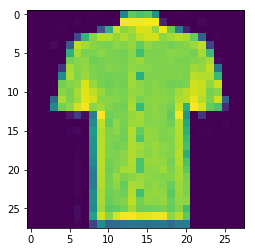


True class: Shirt
Predicted class: Pullover
Misclassified 105 times


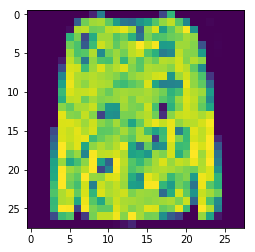


True class: Coat
Predicted class: Pullover
Misclassified 91 times


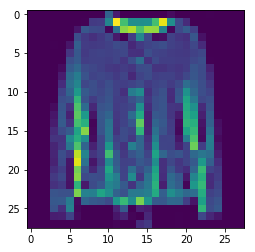


True class: Shirt
Predicted class: Coat
Misclassified 75 times


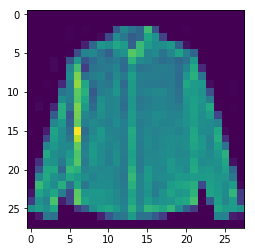


True class: T-shirt/top
Predicted class: Shirt
Misclassified 69 times


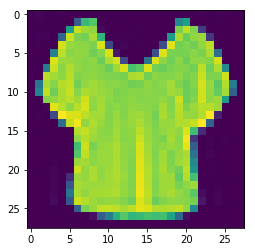


True class: Coat
Predicted class: Shirt
Misclassified 48 times


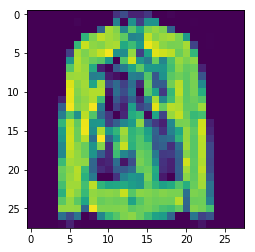


True class: Pullover
Predicted class: Coat
Misclassified 45 times


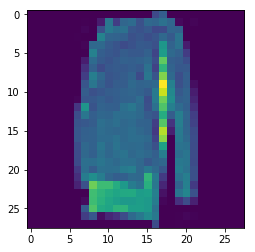


True class: Pullover
Predicted class: Shirt
Misclassified 36 times


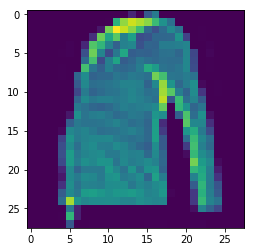


True class: Dress
Predicted class: Coat
Misclassified 35 times


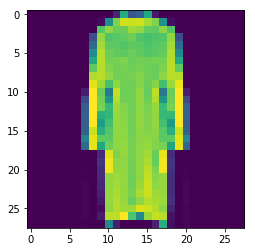


True class: Ankle boot
Predicted class: Sneaker
Misclassified 33 times


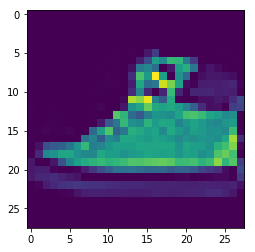

In [29]:
comm_matrix(conv_model_3c_2d_do10, x_test_prep_3d, y_test)

# Five Layers

In [30]:
model_6c_2d_2p_do10 = Sequential()
model_6c_2d_2p_do10.add(Conv2D(64, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model_6c_2d_2p_do10.add(Dropout(0.1))
model_6c_2d_2p_do10.add(Conv2D(64, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model_6c_2d_2p_do10.add(MaxPooling2D(pool_size=(2, 2)))
model_6c_2d_2p_do10.add(Dropout(0.1))
model_6c_2d_2p_do10.add(Conv2D(64, (3, 3), activation='sigmoid'))
model_6c_2d_2p_do10.add(MaxPooling2D(pool_size=(2, 2)))
model_6c_2d_2p_do10.add(Dropout(0.1))
model_6c_2d_2p_do10.add(Conv2D(128, (3, 3), activation='sigmoid'))
model_6c_2d_2p_do10.add(Dropout(0.1))
model_6c_2d_2p_do10.add(Conv2D(128, (3, 3), activation='sigmoid'))
model_6c_2d_2p_do10.add(Flatten())
model_6c_2d_2p_do10.add(Dense(64, activation='sigmoid'))
model_6c_2d_2p_do10.add(Dropout(0.1))
model_6c_2d_2p_do10.add(Dense(10, activation='softmax'))

optimizer = Adam()
model_6c_2d_2p_do10.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[sparse_categorical_accuracy])

conv_model_6c_2d_2p_do10 = ConvModel(model_6c_2d_2p_do10)
conv_model_6c_2d_2p_do10.fit(x_train_prep_3d, y_train, batch_size=32, epochs=40, validation_data=(x_test_prep_3d, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 454s 8ms/step - loss: 2.3088 - sparse_categorical_accuracy: 0.1011 - val_loss: 2.3036 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/40
60000/60000 [==============================] - 452s 8ms/step - loss: 1.4677 - sparse_categorical_accuracy: 0.4312 - val_loss: 0.5881 - val_sparse_categorical_accuracy: 0.7769
Epoch 3/40
60000/60000 [==============================] - 453s 8ms/step - loss: 0.5335 - sparse_categorical_accuracy: 0.7944 - val_loss: 0.4709 - val_sparse_categorical_accuracy: 0.8206
Epoch 4/40
60000/60000 [==============================] - 459s 8ms/step - loss: 0.4604 - sparse_categorical_accuracy: 0.8261 - val_loss: 0.4289 - val_sparse_categorical_accuracy: 0.8336
Epoch 5/40
60000/60000 [==============================] - 451s 8ms/step - loss: 0.4213 - sparse_categorical_accuracy: 0.8417 - val_loss: 0.4039 - val_sparse_categorical_accuracy: 0.8497
Epoch 6/40
60000/600

Confusion matrix:
[[865   1  18   9   2   1  95   0   9   0]
 [  2 982   0   9   2   0   3   0   2   0]
 [ 17   0 882   9  41   0  48   0   3   0]
 [ 17   4   9 909  37   0  22   0   2   0]
 [  1   1  59  13 856   0  70   0   0   0]
 [  0   0   0   0   0 976   0  15   0   9]
 [128   2  73  15  60   0 707   0  15   0]
 [  0   0   0   0   0   6   0 985   0   9]
 [  4   1   4   2   1   1   2   2 983   0]
 [  0   0   0   0   0   5   0  40   1 954]]

True class: Shirt
Predicted class: T-shirt/top
Misclassified 128 times


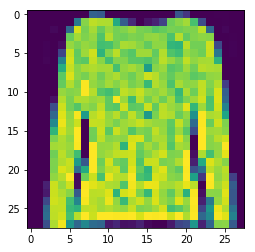


True class: T-shirt/top
Predicted class: Shirt
Misclassified 95 times


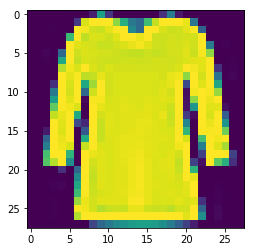


True class: Shirt
Predicted class: Pullover
Misclassified 73 times


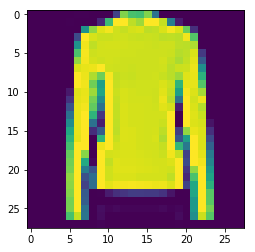


True class: Coat
Predicted class: Shirt
Misclassified 70 times


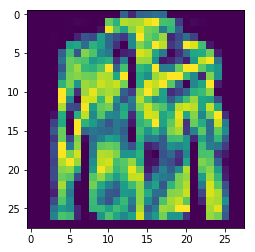


True class: Shirt
Predicted class: Coat
Misclassified 60 times


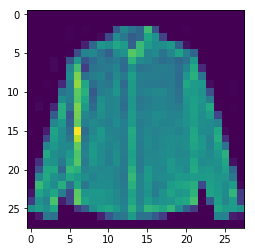


True class: Coat
Predicted class: Pullover
Misclassified 59 times


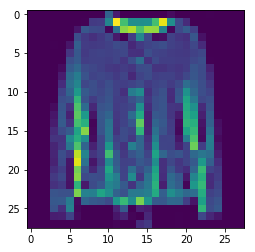


True class: Pullover
Predicted class: Shirt
Misclassified 48 times


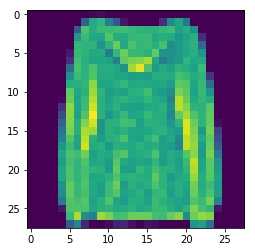


True class: Pullover
Predicted class: Coat
Misclassified 41 times


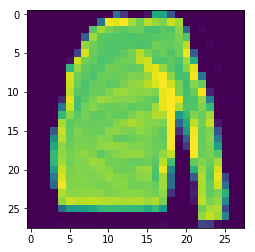


True class: Ankle boot
Predicted class: Sneaker
Misclassified 40 times


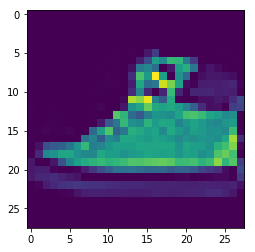


True class: Dress
Predicted class: Coat
Misclassified 37 times


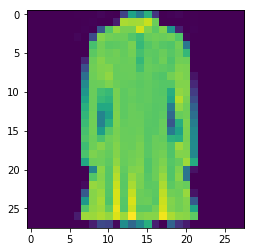

In [31]:
comm_matrix(conv_model_6c_2d_2p_do10, x_test_prep_3d, y_test)
